# \$50k Classification Project

### Joseph Harvey, July 2021

In this analysis, I aim to predict whether a person makes more or less than $50k based on a variety of factors, including education, race, and marital status, among others.

In [51]:
#importing needed classes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier

## 1. Importing and Exploring the Data

We begin by importing our training and testing sets as pandas dataframes. Taking a glimpse at the testing data .csv file in Excel, we notice that, in the class column, there is an unwanted period after each entry. We also notice, in both files, that some entries have '?' where a column entry is unknown. So, let's remove all rows with a '?' in them and trim those periods from the 'class' column in the test data.

In [52]:
df_train = pd.read_csv('au_train.csv', skipinitialspace = True)
df_test = pd.read_csv('au_test.csv', skipinitialspace = True)

#Remove all entries with '?'
indices_to_drop = np.where(df_train =='?')[0]
df_train = df_train.drop(indices_to_drop)

indices_to_drop = np.where(df_test =='?')[0]
df_test = df_test.drop(indices_to_drop)

#Remove '.' from '<=50K.' and '>50K.' in testing data
df_test = df_test.replace('<=50K.', '<=50K')
df_test = df_test.replace('>50K.', '>50K')

/Users/josephharvey/opt/anaconda3/lib/python3.8/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


Let's take a quick look at that dataframe:

In [53]:
df_train.head(10)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
5,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
6,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,<=50K
7,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K
8,31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,>50K
9,42,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,>50K


We begin with some exploratory data visualization. 
We first look at the counts of the two income classes (greater or less than $50k).

<=50K    22654
>50K      7508
Name: class, dtype: int64


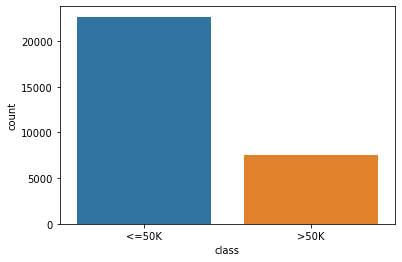

In [78]:
print(df_train['class'].value_counts())
sns.set_context(rc = {'patch.linewidth': 0.0})
sns.countplot(x="class", data=df_train)

We have imbalanced classes, with about 3x more examples of the <=50k class! Let's keep that in mind as we explore the data.

Let's take a look at income class broken down by race:

Text(0, 0.5, 'fraction of category')

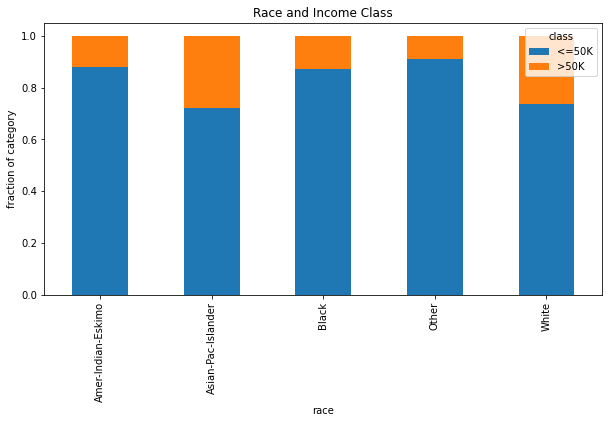

In [55]:
#race
table=pd.crosstab(df_train['race'], df_train['class'])
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', figsize = (10,5), stacked=True)
plt.title('Race and Income Class')
plt.ylabel('fraction of category')

In the above plot, for for all races a <=50k class is more likely. However, whites and Asian/Pacific Islanders have a slightly greater proportion of the >50K class. Still, this doesn't look like an extremely valuable feature.

Text(0, 0.5, 'fraction of category')

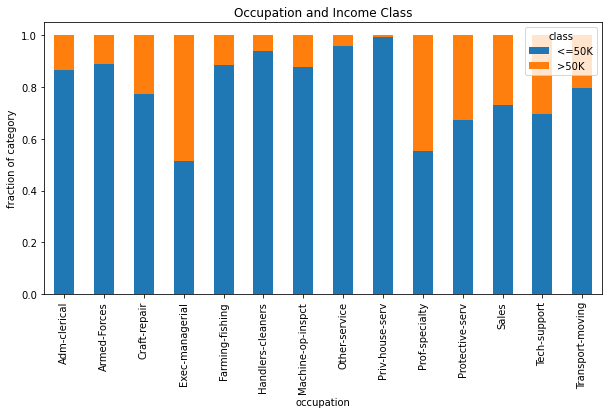

In [56]:
#occupation
table=pd.crosstab(df_train['occupation'], df_train['class'])
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', figsize = (10,5), stacked=True)
plt.title('Occupation and Income Class')
plt.ylabel('fraction of category')

Occupation, as expected, gives good seperation between high-paying jobs like Executive/Managerial and professional/speciality jobs and lower paying jobs like service, farming, and private house servants.

Text(0, 0.5, 'fraction of category')

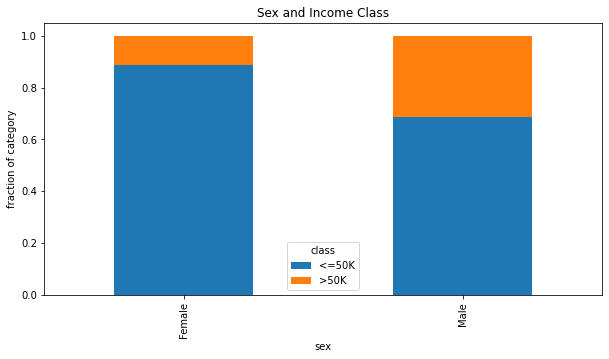

In [57]:
#sex
table=pd.crosstab(df_train['sex'], df_train['class'])
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', figsize = (10,5), stacked=True)
plt.title('Sex and Income Class')
plt.ylabel('fraction of category')

Sex seems like a good differentiator for the two classes.

Text(0, 0.5, 'count')

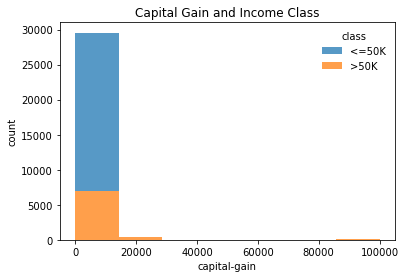

In [77]:
#capital gain
sns.histplot(df_train, x='capital-gain', bins = 7, hue='class', multiple="stack")
plt.title('Capital Gain and Income Class')
plt.ylabel('count')

It is unclear from this graph whether capital gains is a valuable feature or not. (I later tried added it to the features in the logistic regression, and it did not improve accuracy very much.)

Text(0, 0.5, 'count')

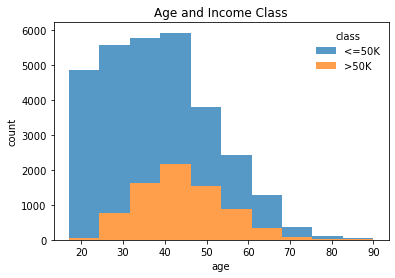

In [79]:
#age
sns.histplot(df_train, x='age', bins = 10, hue='class', multiple="stack")
plt.title('Age and Income Class')
plt.ylabel('count')

Age is clearly a very valuable feature - as age increases up to about 60, the proportion of people in the >50K increases.

Text(0, 0.5, 'fraction of category')

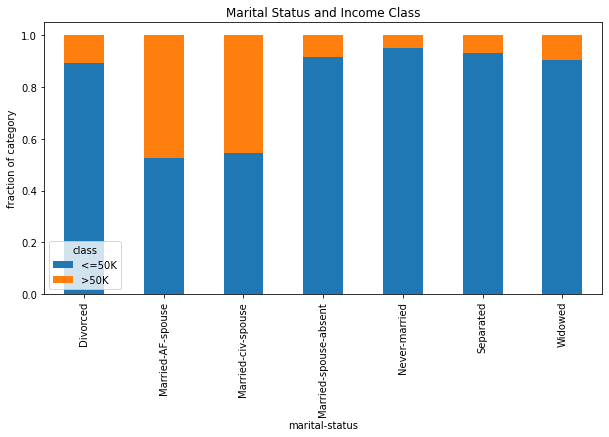

In [59]:
#marital status
table=pd.crosstab(df_train['marital-status'], df_train['class'])
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', figsize = (10,5), stacked=True)
plt.title('Marital Status and Income Class')
plt.ylabel('fraction of category')

This plot reveals that those who are married are much more likely to make >50K! This is probably a valuable feature.

Let's look at education, which we might expect to have the most significant impact. But first, let's reduce the number of classes within education: as a first stab, we'll reduce it to "Pre-HS-grad", "HS-grad", "Some-college", "Assoc", "Bachelors", "Masters", "Prof-school", and "Doctorate". That is, we lump everything together that is prior to high school graduation, and we'll combine the two types of Associate degree. 

In [60]:
#Simplyfying education in training set
df_train['education']=np.where(df_train['education'] =='Preschool', 'Pre-HS-grad', df_train['education'])
df_train['education']=np.where(df_train['education'] =='1st-4th', 'Pre-HS-grad', df_train['education'])
df_train['education']=np.where(df_train['education'] =='5th-6th', 'Pre-HS-grad', df_train['education'])
df_train['education']=np.where(df_train['education'] =='7th-8th', 'Pre-HS-grad', df_train['education'])
df_train['education']=np.where(df_train['education'] =='9th', 'Pre-HS-grad', df_train['education'])
df_train['education']=np.where(df_train['education'] =='10th', 'Pre-HS-grad', df_train['education'])
df_train['education']=np.where(df_train['education'] =='11th', 'Pre-HS-grad', df_train['education'])
df_train['education']=np.where(df_train['education'] =='12th', 'Pre-HS-grad', df_train['education'])
df_train['education']=np.where(df_train['education'] =='Assoc-voc', 'Assoc', df_train['education'])
df_train['education']=np.where(df_train['education'] =='Assoc-acdm', 'Assoc', df_train['education'])

#Simplyfying education in testing set
df_test['education']=np.where(df_test['education'] =='Preschool', 'Pre-HS-grad', df_test['education'])
df_test['education']=np.where(df_test['education'] =='1st-4th', 'Pre-HS-grad', df_test['education'])
df_test['education']=np.where(df_test['education'] =='5th-6th', 'Pre-HS-grad', df_test['education'])
df_test['education']=np.where(df_test['education'] =='7th-8th', 'Pre-HS-grad', df_test['education'])
df_test['education']=np.where(df_test['education'] =='9th', 'Pre-HS-grad', df_test['education'])
df_test['education']=np.where(df_test['education'] =='10th', 'Pre-HS-grad', df_test['education'])
df_test['education']=np.where(df_test['education'] =='11th', 'Pre-HS-grad', df_test['education'])
df_test['education']=np.where(df_test['education'] =='12th', 'Pre-HS-grad', df_test['education'])
df_test['education']=np.where(df_test['education'] =='Assoc-voc', 'Assoc', df_test['education'])
df_test['education']=np.where(df_test['education'] =='Assoc-acdm', 'Assoc', df_test['education'])

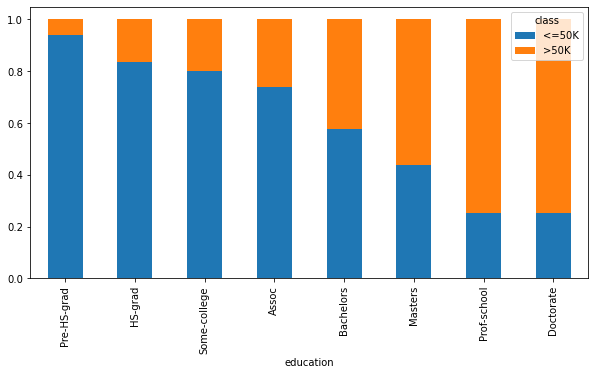

In [61]:
#make stacked barplot for education
table=pd.crosstab(df_train['education'], df_train['class'])
order = ['Pre-HS-grad', 'HS-grad', 'Some-college', 'Assoc', 'Bachelors', 'Masters', 'Prof-school', 'Doctorate']
table = table.reindex(order, axis = 'rows')
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', figsize = (10,5), sort_columns=False, stacked=True)

From this graph, we can  see that up until post-grad level education, a person is more likely to make less than \\$50k. Beginning with masters on up, one is more likely to make over \\$50k. Education is clearly a very valuable feature which separates the two classes.

Now that we've explored our data, let's try a logistic regression on this data and see how it performs.

## 2. Logistic Regression Model

Given that this is a binary classification task, let's try a binary logistic regression model. 

Let's select only a subset of the features in the training set, choosing what we think will be valuable for the model and eliminating features which are obviously highly correlated (e.g., marital status and relationship). Here, we choose only the 'age', 'marital-status', 'education', 'hours-per-week', and 'occupation' features.

We create our dummy variables and train the logistic regression model. For the logistic regression, we count a '>50K' class as a 1, and '<=50K' as 0.

In [62]:
#selecting desired columns
df_train_small = df_train[['age', 'marital-status', 'education', 'hours-per-week', 'occupation', 'class']]
df_test_small = df_train[['age', 'marital-status', 'education', 'hours-per-week', 'occupation', 'class']]

#create dummies
df_train_dummies = pd.get_dummies(df_train_small)
df_test_dummies = pd.get_dummies(df_test_small)

#separate dependent and independent variables
df_train_X = df_train_dummies.drop(["class_<=50K", "class_>50K"], axis=1)
df_train_y = df_train_dummies["class_>50K"]

df_test_X = df_test_dummies.drop(["class_<=50K", "class_>50K"], axis=1)
df_test_y = df_test_dummies["class_>50K"]

#create logistic regression model using the liblinear solver (I tried a couple different solvers, and this one
#allows the model to converge)
logreg = LogisticRegression(solver = 'liblinear')

#train the model and get predictions based on the testing data
logreg.fit(df_train_X, df_train_y)
df_pred_y = logreg.predict(df_test_X)

It seems that the model was trained successfully. Let's test it and evaluate the results.

## 3. Evaluating the Performance of the Logistic Regression Model

Let's get the confusion matrix and accuracy score for our logistic regression model.

Log Regression Accuracy: 0.8421855314634308


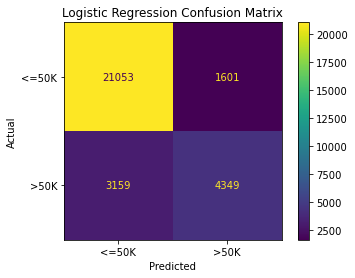

In [63]:
#confusion matrix
cm = confusion_matrix(df_test_y, df_pred_y)

cmd_obj = ConfusionMatrixDisplay(cm, display_labels=['<=50K', '>50K'])
cmd_obj.plot()
cmd_obj.ax_.set(
                title='Logistic Regression Confusion Matrix', 
                xlabel='Predicted', 
                ylabel='Actual')
print("Log Regression Accuracy: " + str(accuracy_score(df_test_y, df_pred_y)))

Looking at the confusion matrix, our model does well at correctly predicting <=50K cases; when a datapoint is <=50K, it classifies it with an accuracy of 20832/(20832+1822) = 0.91. It does significantly worse with >50K cases, as expected, with an accuracy of 4098/(4098+3410) = 0.55 for those cases. Improving this model should focus on reducing the misclassifications of >50K cases.

Based on this confusion matrix, the overall accuracy of the logistic regression model is 0.83. Let's compare this to a naive classifier which always predicts <=50K, since so many more people are in that category. 

In [64]:
#find how many of each class are in the testing set
df_test['class'].value_counts()

<=50K    11360
>50K      3700
Name: class, dtype: int64

A naive classifier which always guesses <=50K would have an accuracy of 22654/(22654+7508) = 0.75. So, we see that our logistic regression model does better than a naive classifier, but clearly there's a lot of room for improvement here.

Now let's generate the ROC curve for this logistic regression model.

AUC: 0.8978053291227004


Text(0, 0.5, 'True Positive Rate')

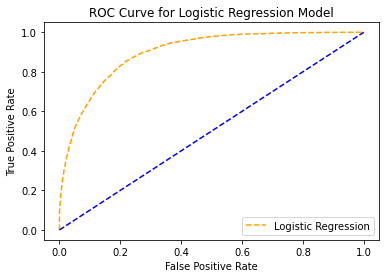

In [65]:
#get ROC for logreg model
pred_prob = logreg.predict_proba(df_test_X)
fpr, tpr, thresh = roc_curve(df_test_y, pred_prob[:,1], pos_label=1)

random_probs = [0 for i in range(len(df_test_y))]
p_fpr, p_tpr, _ = roc_curve(df_test_y, random_probs, pos_label=1)

auc_score = roc_auc_score(df_test_y, pred_prob[:,1])
print("AUC: " + str(auc_score))

plt.plot(fpr, tpr, linestyle = '--', color = 'orange', label = 'Logistic Regression')
plt.plot(p_fpr, p_tpr, linestyle = '--', color = 'blue')
plt.legend(loc='best')

# title
plt.title('ROC Curve for Logistic Regression Model')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive Rate')

So, our logistic regression model has an AUC of 0.88. A random classifier has an AUC of 0.5, so this classifier is doing much better than random guessing.

## 4. Random Forest Classifier

Let's see if we can't beat the performance of our logistic regression model with a random forest classifier. We'll use exactly the same data that we used to train the logistic regression model.

Random Forest Classifier Accuracy: 0.9133678138054505


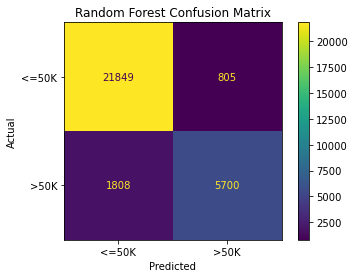

In [66]:
rfc = RandomForestClassifier(max_depth=20, random_state=0)
rfc.fit(df_train_X, df_train_y)

pred_y = rfc.predict(df_test_X)

#confusion matrix
cm = confusion_matrix(df_test_y, pred_y)

cmd_obj = ConfusionMatrixDisplay(cm, display_labels=['<=50K', '>50K'])
cmd_obj.plot()
cmd_obj.ax_.set(
                title='Random Forest Confusion Matrix', 
                xlabel='Predicted', 
                ylabel='Actual')
print("Random Forest Classifier Accuracy: " + str(accuracy_score(df_test_y, pred_y)))

So, our random forest classifier, with an accuracy of 0.91 solidly outperforms our logistic regression model. The improvement largely comes from more accurately classifying instances of the >50K class. Let's put the ROC curves for both models together to see how they compare.

AUC: 0.9715601701376981


Text(0, 0.5, 'True Positive Rate')

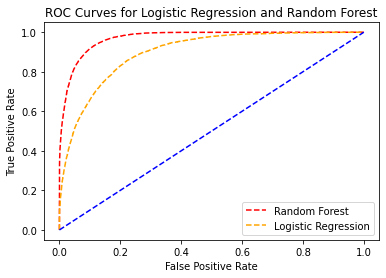

In [67]:
#get ROC for logreg model
rf_pred_prob = rfc.predict_proba(df_test_X)
rf_fpr, rf_tpr, rf_thresh = roc_curve(df_test_y, rf_pred_prob[:,1], pos_label=1)

auc_score_rf = roc_auc_score(df_test_y, rf_pred_prob[:,1])
print("AUC: " + str(auc_score_rf))

plt.plot(rf_fpr, rf_tpr, linestyle = '--', color = 'red', label = 'Random Forest')
plt.plot(fpr, tpr, linestyle = '--', color = 'orange', label = 'Logistic Regression')
plt.plot(p_fpr, p_tpr, linestyle = '--', color = 'blue')
plt.legend(loc='best')

# title
plt.title('ROC Curves for Logistic Regression and Random Forest')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive Rate')

Comparing the ROC curves, as well as AUC scores, confirms that the random forest classifier does a much better job at predicting income class than the logistic regression model. The random forest has an AUC of 0.97 vs. 0.88 for the logistic regression. 

## 5. Paths to Improvement

Although the classes in the training set, at about a 3:1 ratio, are somewhat imbalanced, this is probably not enough of an imbalance to cause great concern, and the random forest classifier sees decent accuracy without any effort to balance the classes. Further work could be done to balance the classes for training while ensuring that the model performs well on test data with unbalanced <=50K and >50K classes.

Addtionally, we could be a little more scientific about selecting the features to train on. Here, we use an approach which uses data visualization and exploration, as well as intuition, to inform an intelligent guess as to which features are valuable, and this yields decent results. The models could be further optimized by using a more sophisticated and methodical method to ensure the most valuable features are chosen, and to increase feature independence.